# Machine Learning Engineer Nanodegree
## Capstone Project
Andrew O'Gorman - August 09, 2018


## I. Definition

### Project Overview
For my Capstone project I will be using a deep learning approach to attempt to solve the Humpback Whale Identification project on [Kaggle](https://www.kaggle.com/c/whale-categorization-playground). This is a similar image classification problem to the dog breed classification challenge in the Deep Learning section of the Machine Learning Nanodegree. I have chosen this domain as I care deeply about our oceans and maritime life. I have been fascinated by whales since visiting the [Natural History Museum](http://www.nhm.ac.uk/discover/news/2017/july/museum-unveils-hope-the-blue-whale-skeleton.html), London, as a child with my father and seeing the full skeleton of the blue whale. They are truly magnificent creatures; giants of the ocean and I feel passionately about helping organisations that support and monitor them. This project appeals to me as the work will help contribute to [Happy Whale's](https://happywhale.com/home) understanding of the movement of whales by using machine learning to dramatically increase the efficiency of this identification work. 

Whale tails (referred to as 'Flukes') are like a barcode or fingerprint, with enough information to identify an individual whale. [Traditionally](https://www.nationalgeographic.com/adventure/adventure-blog/2016/05/04/whos-that-whale-your-photo-could-help-i-d-a-humpback/), scientists and marine biologists have taken and amassed large numbers of photograpahs of whales and then had to manually attempt to match newly photographed whales with historic images. This process is time consuming and prone to a high degree of error, also there are challenges around getting the pictures due to the geographical spread of whales and the amount of time spent underwater. These are some of the reasons why this problem suits a machine learning approach.

Previous work was done at the [University of Texas](https://link.springer.com/chapter/10.1007/3-540-45103-X_16) in 2003 to identify Humpback and Gray Whales using a patch-matching technique as a follow-up phase to WhaleNet once they specified the fluke type. More recently a team at the [University of Catalunya in Barcelona](https://arxiv.org/pdf/1604.05605.pdf) used convolutional neural networks to test the feasibility of using deep learning in whale recognition using the NOAA Fisheries dataset. Their paper outlines a successful approach to applying CNNs to identification of the heads of whales and so this seems like a good approach to build upon in this capstone project.

I am keen to test my understanding of image recognition using Deep Learning as there are several additional projects I would like to conduct upon completion of my Nanodegree and so hope this Capstone Project will be the foundation of further work for me in this field.

The dataset I will be using to train the model can be found [here](https://www.kaggle.com/c/whale-categorization-playground/download/train.zip) and the testing dataset [here](https://www.kaggle.com/c/whale-categorization-playground/download/test.zip).

### Problem Statement
The problem is to use the existing dataset of whale fluke images to build an understanding of each whale's unique characteristics of their tails. By using this understanding, we should then be able to take a new picture of a whale fluke and determine whether it matches a previously seen whale or whether it is in fact a new whale not previously seen in our dataset. 

This problem is an image recognition challenge given the unique features of a [whale's fluke](http://www.alaskahumpbacks.org/matching.html) as seen below:

<img src="files/fluke.jpg">

This problem is a good one to solve as understanding and tracking whale populations across the globe will help in several fields including ocean conservation and global climate change. 

### Metrics
The owners of the Kaggle competition hold a labelled list of the 15,611 testing images which result submissions are compared against. For each image in the test set I will predict up to 5 labels for the whale ID (e.g. **w_1287fbc**), where a whale is not predicted to be one of the existing whales in the training data they will be labelled as **new_whale**. The submissions file will contain a header and have the following format:

    Image,Id
    
    00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
    
    0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46

The submissions are evaluated according to the Mean Average Precision (MAP) as seen below:

    MAP@5 = \frac{1}{U} \sum_{u=1}^{U}  \sum_{k=1}^{min(n,5)} P(k)

Where **U** is the number of images, **P(k)** is the precision at cut-off **k**, and **n** is the number predictions per image. Scores are between 0 and 1 with a score of 1 being a perfect match with no error.


## II. Analysis

### Data Exploration
The dataset I am using was provided by Happy Whale, a citizen science organisation helping to track individual whales throughout the world's oceans. The images were gathered from research institutions and public contributions. The images specifically targeted whale flukes with the aim of being used to help identify the migration patterns of whales over time so as a dataset is ideally suited to the proposed problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

training_df = pd.read_csv('../capstone/train.csv')
number_whales = len(training_df['Id'].unique())

print("Total images in the training data =",len(os.listdir("../capstone/train")) )
print("Total images in the test data = ",len(os.listdir("../capstone/test")))
print("Total unique whales in training data =",number_whales)

Total images in the training data = 9850
Total images in the test data =  15610
Total unique whales in training data = 4251


### Exploratory Visualization
The dataset I am using was provided by Happy Whale, a citizen science organisation helping to track individual whales throughout the world's oceans. The images were gathered from research institutions and public contributions. The images specifically targeted whale flukes with the aim of being used to help identify the migration patterns of whales over time so as a dataset is ideally suited to the proposed problem.

| Colour landscape | Grayscale and blurry | Colour portrait |
| - | - | - |
|<img src="files/train/6c54a646.jpg">|<img src="files/train/e976465c.jpg">|<img src="files/train/ea5f45ca.jpg">|

I will first look to pre-process the data to standardise the size, colour and proportions of all the images. This will allow me to build, train and test a deep learning algorithm to help identify whales within the dataset. The data is already split into training and testing sets, however, I will look to further subdivide the training set as I build my model.


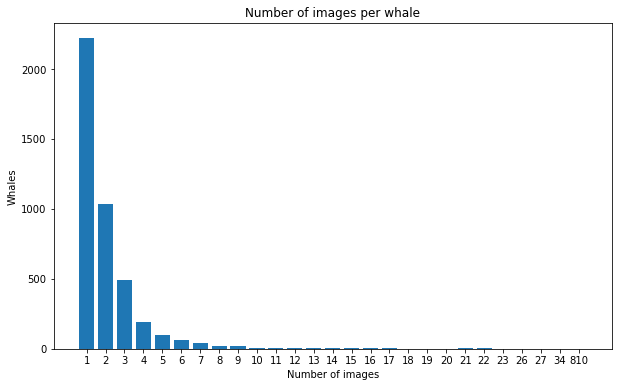

In [9]:
import math
from collections import Counter

buckets = Counter(training_df['Id'].value_counts().values)

plt.figure(figsize=(10, 6))
plt.bar(range(len(buckets)), list(buckets.values())[::-1])
plt.xticks(range(len(buckets)), list(buckets.keys())[::-1])
plt.title("Number of images per whale")
plt.xlabel('Number of images')
plt.ylabel('Whales')

plt.show()

Initial analysis of the data reveals that of the 4251 whales in the dataset over 2000 of them have only one image, with around 4000 of the whales having less than 5 images to train on. I will therefore use Data Augmentation to help boost the number of training images for each whale which I will discuss below.

In [16]:
from PIL import Image

def is_grey_scale(img_path):
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

greyscale = [is_grey_scale(f'../capstone/train/{i}') for i in training_df['Image'].sample(frac=0.1)]
grey_percentage = round(sum([i for i in greyscale]) / len([i for i in greyscale]) * 100, 2)

print(f"Percentage of grey images: {grey_percentage}")

Percentage of grey images: 48.93


By using the above [code]((https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli) we can see that we have almost an equal split of grayscale and colour images in the training data set. I will therefore look to convert all images (both training and testing) to greyscale in my data pre-processing step.

Given the three images above are all different sizes I can also explore how the size of the images varies across the dataset.

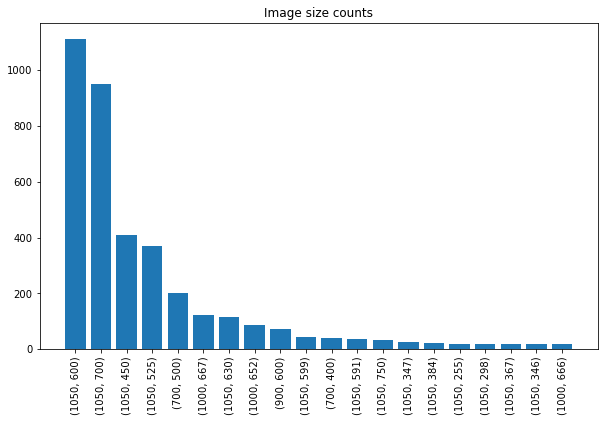

In [13]:
img_sizes = Counter([Image.open(f'../capstone/train/{i}').size for i in training_df['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=90)
plt.title("Image size counts")

plt.show()

As we can clearly see the image size varies significantly across the dataset. I will look to address this in the Data pre-processing section

### Algorithms and Techniques
I will be using a Deep Learning approach for this image identification problem. Deep Learning makes use of neural networks which aim to mimic how the brain operates with neurons used to fire pieces of information through a network to produce an output. By using this approach and building complex neural networks, Deep Learning can be more effective at determining the important features in a given image than a human. 

Specifically, I intend to use Convolutional Neural Networks (CNNs) for this problem. I have chosen to use CNNs for several reasons:

-  CNNs maintain spatial information by taking matrices as inputs when compared to traditional Multilayer Perceptrons. This allows us to use fewer weights as some parameters are shared, hence lowering the computational cost and training time.

- CNNs work well across images where there are distortions due to lighting conditions, horizontal/vertical shifts, different poses etc.

- They are very good at identifying patterns within images by using filters to find specific groups of pixel groupings that are important.

### Benchmark
The benchmark score I will be comparing against was achieved using a technique known as [Perceptual hashing](https://en.wikipedia.org/wiki/Perceptual_hashing) (pHash). The pHash algorithm produces a fingerprint for each image which are analogous if features in the images are similar. This technique has been used previously to identify cases of online copyright infringement and also in digital forensics work due to its ability to have a correlation between hashes so similar images can be identified. 

The pHash technique is able to identify which whale IDs the image is most similar to and then submit their 5 most likely matches for each image. This benchmark submission was then measured using the MAP formula below to get a Mean Average Position score of 0.36075.

## III. Methodology

### Data Preprocessing

For this project I took several steps to pre-process and also augment the data. In the code below you will find the following steps:

* import required Python libraries
* loading of training and testing data
* generation of pHash values to identify perfect matches
* conversion of data into dataframes
* conversion of all images to greyscale
* conversion of all images to standard size

Having researched the pHash technique I decided it would be useful for this project to generate the pHash for each image to help identify duplicate images. I was able to later use this pHash value to identify perfect matches of images in the training and testing dataset and eventually used this check in my final pipeline.

In [46]:
# import Python, sklearn and keras libraries

import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.pylab as plt
import scipy.fftpack

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [47]:
# define pHash functions and then generate pHash values for each of the training images

def _binary_array_to_hex(arr):
    h = 0
    s = []
    for i, v in enumerate(arr.flatten()):
        if v: 
            h += 2**(i % 8)
        if (i % 8) == 7:
            s.append(hex(h)[2:].rjust(2, '0'))
            h = 0
    return "".join(s)

class ImageHash(object):
    def __init__(self, binary_array):
        self.hash = binary_array
    def __str__(self):
        return _binary_array_to_hex(self.hash.flatten())
    def __repr__(self):
        return repr(self.hash)
    def __sub__(self, other):
        if other is None:
            raise TypeError('Other hash must not be None.')
        if self.hash.size != other.hash.size:
            raise TypeError('ImageHashes must be of the same shape.', self.hash.shape, other.hash.shape)
        return (self.hash.flatten() != other.hash.flatten()).sum()
    def __eq__(self, other):
        if other is None:
            return False
        return numpy.array_equal(self.hash.flatten(), other.hash.flatten())
    def __ne__(self, other):
        if other is None:
            return False
        return not numpy.array_equal(self.hash.flatten(), other.hash.flatten())
    def __hash__(self):
        # this returns a 8 bit integer, intentionally shortening the information
        return sum([2**(i % 8) for i, v in enumerate(self.hash.flatten()) if v])

def phash(image, hash_size=8, highfreq_factor=4):
    img_size = hash_size * highfreq_factor
    image = image.convert("L").resize((img_size, img_size), Image.ANTIALIAS)
    pixels = np.array(image.getdata(), dtype=np.float).reshape((img_size, img_size))
    dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
    dctlowfreq = dct[:hash_size, :hash_size]
    med = np.median(dctlowfreq)
    diff = dctlowfreq > med
    return ImageHash(diff)

def getImageMetaData(file_path):
    with Image.open(file_path) as img:
        img_hash = phash(img)
        return img.size, img.mode, img_hash

def get_train_input():
    train_input = pd.read_csv(r"../capstone/train.csv")
    m = train_input.Image.apply(lambda x: getImageMetaData(r"../capstone/train/" + x))
    train_input["Hash"] = [str(i[2]) for i in m]
    train_input["Shape"] = [i[0] for i in m]
    train_input["Mode"] = [str(i[1]) for i in m]
    train_input["Length"] = train_input["Shape"].apply(lambda x: x[0]*x[1])
    train_input["Ratio"] = train_input["Shape"].apply(lambda x: x[0]/x[1])
    train_input["New_Whale"] = train_input.Id == "new_whale"
    img_counts = train_input.Id.value_counts().to_dict()
    train_input["Id_Count"] = train_input.Id.apply(lambda x: img_counts[x])
    return train_input

train_input = get_train_input()

As later discussed in the Refinement section I transformed the training dataset to remove the images that were labelled 'new_whale'. As was shown in the Exploratory Analysis section this category had 810 images, far outweighing any of the other label categories. As this category essentially contained unlabelled images from a variety of different whale's flukes it was causing issues with the model when attempting to identify patterns across this category. 

Given this was the largest category by some way I decided to remove it from the training data so my model could learn more effectively. As the Kaggle competition allowed for up to five guesses for the correct label I hardcoded one of the guesses in this case to be 'new_whale' to mitigate for removal of this category earlier in the project.

In [48]:
# import the data into dataframes

train_images = glob("../capstone/train/*jpg")
test_images = glob("../capstone/test/*jpg")
df = pd.read_csv("../capstone/train.csv")

# remove new_whale labelled images from df and train_images

df_others = df.loc[(df["Id"]!="new_whale")]
df_others_list = df_others['Image'].tolist()

new_list = []
for i in df_others_list:
    new_list.append("../capstone/train/"+i)

df = df_others
train_images = new_list

# generate Image to Label mapping

df["Image"] = df["Image"].map( lambda x : "../capstone/train/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

As my exploratory analysis showed, there was roughly an equal split of colour and greyscale images in the dataset. I used the code below to convert all training images to greyscale. We also saw how the size of the images in the dataset varied, the below code was used to convert all images to size 100 pixels x 100 pixels

I would later use this function to also convert all the testing images to greyscale and 100x100 size.

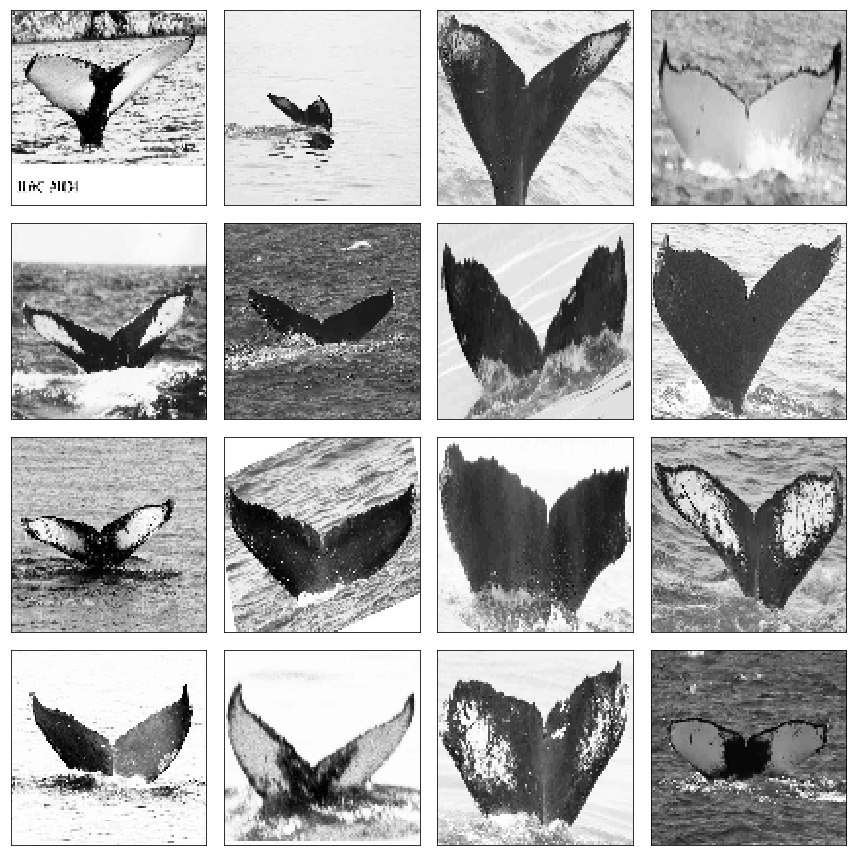

In [49]:
#resize images and convert to black and white

SIZE = 100

def ImportImage(filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]

train_img = np.array([ImportImage(img) for img in train_images])
x = train_img

# check to see if resizing and greyscale conversion have worked

def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()

plotImages(x)

As can be seen from the displayed images, the greyscale conversion and resizing worked and so I was able to move onto the Data Augmentation stage. 

Before starting this I needed to transform the training data for use in the Convolutional Neural Net, in order to do this I used One Hot Encoding. This technique allowed me to assign each categorical label (e.g. whale label) and convert this into an integer and then map each of the training images to this new integer value ready for input into the CNN.

In [52]:
#one hot encoding of the images

class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self,x):
        features = self.le.fit_transform(x)
        return self.ohe.fit_transform(features.reshape(-1,1))
    def transform(self, x):
        return self.ohe.transform(self.la.transform(x.reshape(-1,1)))
    def inverse_tranform(self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform(x))
    def inverse_labels(self, x):
        return self.le.inverse_transform(x)

y = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
y_cat = lohe.fit_transform(y)

### Data Augmentation

As was evident from the exploratory analysis, the number of images per whale label for most categories was very low and in many cases just one image. To help boost the training images I decided upon using some heavy data augmentation to build some of this image variation. I used keras ImageDataGenerator to rescale, rotate, shift, zoom and horizontally flip the images. I then visualised some of the augmented images to visually confirm this process.

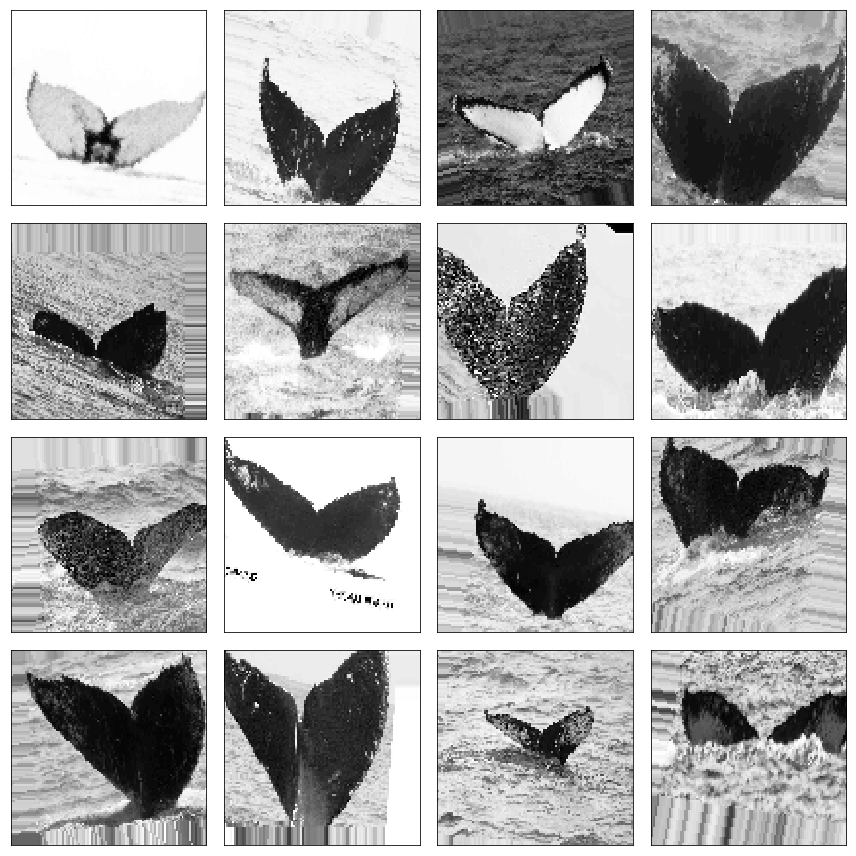

In [53]:
# data augmentation using keras ImageDataGenerator

x = x.reshape( (-1,SIZE,SIZE,1))
input_shape = x[0].shape
x_train = x.astype("float32")
y_train = y_cat

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)

image_gen.fit(x_train, augment=True)

# visualization of this augmentation to check my code

augmented_images, _ = next( image_gen.flow( x_train, y_train.toarray(), batch_size=4*4))
plotImages(augmented_images)

### Implementation

I chose to implement a Convolutional Neural Network for this image detection problem. The biggest challenge here was how to design this network to best fit this type of data problem. I started with what I thought was a fairly simple CNN that would run quickly to test my code with the plan of building in complexity over time.

The CNN I initially built had three Convolutional Layers with the number of features increasing as you progressed through the layers. I used a ReLu activation function in the first layer and the Sigmoid activation functions for each of the next two layers and a kernal size of 3. Each convolutional layer was separated by a MaxPooling layer. At the end of the CNN I had a flatten layer to convert the image matrices into vectors and then several dropout layers (with probability 0.33) to minimise overfitting. Finally I had a dense layer with 4251 nodes, one for each whale type.

For this CNN I decided to use categorical crossentropy loss function as I was attempting to work out which category each image best matched with. I used the Adadelta optimiser for the Gradient Descent challenge as it typically runs faster than the Adam Optimiser. Finally I included the accuracy metric which was what I was hoping to measure.

The initial CNN worked but performed poorly. It struggled to learn and minimise the loss function and also each set of predictions was the same for all test images. I realised that I needed to improve the CNN architecture and also address some of the data inbalancing caused by the large number of training images under the 'new_whale' category.


### Refinement

As explained in the previous section over the course of this project I made several changes to the CNN architecture before settling on the one used to generate my final predictions. There were also several key refinements made to my approach before arriving at my end result.

Firstly after seeing the output of the initial CNN it was clear that I had a problem with data inbalancing as each prediction was the same regardless of the testing image used. I had tried to mitigate the fact that the 'new_whale' category had far more images than any other whale type by introducing weights for each class which was a function of the number of images in each class, however this wasn't having the desired effect. I instead chose to remove all images under the new_whale category from the training data so they wouldn't affect my model. This allowed me to also remove the class weight function I had been using. I mitigated this by recognising that given it was by far the most likely category I would build in part of the prediction function at the end to choose 'new_whale' as one of the five predictions unless it was an exact match.

After learning more about the pHash function to understand the benchmark score better I decided I could usefully implement an aspect of this in my code to identify when there was a perfect match for an image. In these cases, where the pHash of the testing image matched a pHash of a training image, instead of choosing the 5 most likely images I would only predict the one matched image.

I attempted to introduce both an upper and lower limit threshold for predictions, for example when the first of the top 5 predictions exceeded this threshold only predict this one image rather than the top five. Similarly, when the last of the 5 predictions was below the lower confidence limit remove this from the predictions. I started with an upper threshold of 75% confidence and a lower limit of 5% confidence, this had the effect of significantly lowering my final score. I tried several versions of this until eventually settling on just a lower limit of not including predictions of less than 1% confidence.

Finally, once happy with my code I gradually increased the number of epochs the code ran over, initially starting at 10 then 15, 25, 100, 250 before finally running my model over 1000 epochs which took several hours to run.

## IV. Results

### Model Evaluation and Validation

The final model chosen was one that performed most effectively for this image classification problem. 

After several attempts at refining, the CNN the architecture I settled upon had two Convolutional Layers separated by a Max Pooling Function. The convolutional layers both used strides = (1,1) and deployed a ReLu activation function. The features increased from 32 to 64 as it proceeded through the CNN to provide more depth to the classifications as it better understands the image.

I used an AveragePooling layer at the end of the CNN to reduce the size of the preceding layer to (15,15,64) by taking the average of each feature map. The next Flatten layer merely flattens the input, without resulting in any change to the information contained in the previous layer. I used a fully connected Dense layer with 500 nodes and ReLu activation function and then included a Dropout layer (with 0.8 probability) to reduce any overfitting. Finally I passed the data through a dense layer at the end with 4250 nodes, one for each whale type (when you exclude the new_whale type).

For this final CNN I again used categorical crossentropy loss function but this time used the Adam Optimiser instead of Adadelta. Again I included the accuracy metric to measure against.

The previous CNN architecture didn't improve it's learning rate over time and the loss function plateaued. With this architecture I was able to develop a model that not only learnt over time but also managed to minimise the loss function significantly over time. 

The final CNN used can be seen below:

In [ ]:
#build and train model

batch_size = 128
num_classes = len(y_cat.toarray()[0])
epochs = 1000

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

model = Sequential()
model.add(Conv2D(32, (7, 7), strides = (1,1), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), strides = (1,1), activation='relu'))
model.add(AveragePooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

history = model.fit_generator(image_gen.flow(x_train, y_train.toarray(), batch_size=batch_size),
          steps_per_epoch=  x_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1)
          

#class_weight=class_weight_dic
#score = model.evaluate(x_train, y_train, verbose=0)
#print('Training loss: {0:.4f}\nTraining accuracy:  {1:.4f}'.format(*score))

In [ ]:
#final code for generating predictions for testing data and producing sample submission output file

import warnings
from os.path import split

TEST_IMG_PATH = r"../capstone/test"

test_list = []
with open("sample_submission.csv","w") as f:
    with warnings.catch_warnings():
        f.write("Image,Id\n")
        
        warnings.filterwarnings("ignore",category=DeprecationWarning)
        for image in test_images:
            img = Image.open(image)
            img_hash = str(phash(img))
            dataf = train_input[train_input['Hash'].astype(str).str.contains(img_hash)]

            if len(dataf.index) != 0:          
                image_row = train_input.loc[train_input['Hash'] == img_hash]
                image_row_ID = image_row['Id']
                predicted_tags = image_row_ID.iloc[0]
                image = split(image)[-1]
                f.write("%s,%s\n" %(image, predicted_tags))
                
            else:
                img = ImportImage( image)
                x = img.astype( "float32")
                x = image_gen.standardize( x.reshape(1,SIZE,SIZE))
                y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
                top_probs = np.sort(y)[0][::-1][:4]
                
                if top_probs[3] < 0.01:
                    predicted_args = np.argsort(y)[0][::-1][:3]
                    predicted_tags = lohe.inverse_labels(predicted_args)
                    image = split(image)[-1]
                    predicted_tags = " ".join(predicted_tags)
                    predicted_tags = "new_whale" + " " + predicted_tags
                    f.write("%s,%s\n" %(image, predicted_tags))
                
                else:
                    predicted_args = np.argsort(y)[0][::-1][:4]
                    predicted_tags = lohe.inverse_labels(predicted_args)
                    image = split(image)[-1]
                    predicted_tags = " ".join(predicted_tags)
                    predicted_tags = "new_whale" + " " + predicted_tags
                    f.write("%s,%s\n" %(image, predicted_tags))
                

In [43]:
#test to see if output has formatted correctly for submission file, sample first 10 rows

import csv
with open('sample_submission.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for i,row in enumerate(reader):
        print(row)
        if(i >= 9):
            break

{'Id': 'new_whale', 'Image': 'ddbd3d3f.jpg'}
{'Id': 'new_whale w_25ec80a w_b2d937a w_5297ab3 w_73d5489', 'Image': '49537e24.jpg'}
{'Id': 'new_whale w_479e3e5 w_8d46cef w_67de30b w_8d83172', 'Image': 'fc0c2db5.jpg'}
{'Id': 'new_whale w_861cc1c w_e02fe7b w_dbda0d6 w_6202983', 'Image': '99992231.jpg'}
{'Id': 'new_whale w_e4616da w_64830fa w_ace8c54 w_243e33e', 'Image': 'b47133d4.jpg'}
{'Id': 'new_whale w_73d5489 w_b688397 w_cae7677 w_5297ab3', 'Image': '0488fd16.jpg'}
{'Id': 'new_whale w_12c3d3d w_fb2c3fb w_f4c78e5 w_2216a46', 'Image': 'cd121133.jpg'}
{'Id': 'new_whale w_7b035cc w_fba3bde w_0e737d0 w_9ea2cc3', 'Image': '0f958238.jpg'}
{'Id': 'new_whale w_4e03f66 w_40be51f w_5982299 w_09be3ad', 'Image': '4d5d5724.jpg'}
{'Id': 'new_whale w_3572b44 w_eff7e35 w_fe5e78b w_e4f1fcc', 'Image': '33bb94c8.jpg'}


### Justification

Using the results generated from the code above and after submitting my submissions file to the Kaggle competition I was able to achieve a score of 0.44320. This score not only beat the benchmark of 0.36075 but would have achieved a position of 55 (at the time of writing) on the global leaderboard for this Kaggle competition.

The output from my code, as seen in the sample above, is a csv file containing 15,610 rows, each with between one and five predictions for the matching whale label. 

The result shows that there is significant value to be added to this type of problem by applying machine learning and specifically Deep Learning using Convolutional Neural Networks. This approach, whilst not solving the problem within this project did demonstrate how CNNs can be used to improve upon traditional hash matching techniques.

Below is a table detailing how the score of my submissions matched and then exceeded the pHash benchmark as I refined my approach:

| Score |	Description |
|-------|:--------------:|
|0.44320 |	Best score, 1000 epochs with lower threshold |
|0.44160 |	99% upper threshold, 1000 epochs |
|0.43995  |	95% upper threshold, 1000 epochs |
|0.43230 |	Final model run over 250 epochs |
|0.42864 | 90% threshold, 1000 epochs |
|0.41462|	Included pHash matching, 250 epochs |
|0.36075|	pHash Benchmark |
|0.32772 |	Initial CNN architecture, 250 epochs |

## V. Conclusion

### Free-Form Visualization

In this section I wanted to demonstrate how the final model was able to learn over time. 

The original CNN was only able to achieve around 8% accuracy score before plateauing over 250 epochs. With my final CNN model I was able to run over 1000 epochs improving the accuracy score from an initial 0.2% to just over 40% accuracy. 

The visualisation below shows how the model accuracy improved over time as the CNN learned the optimal weights for the model. The accuracy increased at a rate of 4-5% per 50 epochs up until around 300 epochs. After 300 epochs the accuracy rate increase began to slow, however even by 1000 epochs was still increasing at a rate of 1% per 50 epochs.

It would be interesting to see at what point this model stops improving its accuracy rate, however as running over 1000 epochs took several hours this wasn't something I was able to test during this project.

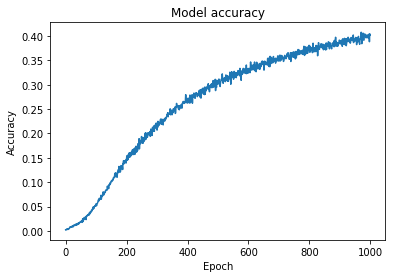

In [19]:
# plot how the accuracy changes as the model was trained over the 1000 epochs

plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

### Reflection

To summarise my project, I chose to look at the whale recognition challenge on Kaggle. The aim of this challenge was to see whether I could build a model that could take images of whale's tails (known as flukes) and match them to other labelled whale flukes. This project was sponsored by a non-profit organisation called Happy Whale who look to help better understand whale migration patterns by tracking whales across the globe using images submitted by the public. 

For this challenge I chose to apply Deep Learning by using Convolutional Neural Networks given their success in other image recognition problems. To begin with I spent time exploring the training data, identifying variation in image size, a near even split of colour to greyscale images and that for many of the whale types there were only one or two images per category. Where this differed was for the 'new_whale' category which had over 800 images.

To test the performance of my model I planned to compare against the pHash benchmark which is a common image hashing technique, this achieved a prediction score of 0.36. 

The first part of my code covered the data pre-processing part of the project. This included converting all images to a standard size and converting all to greyscale. This pre-processing also included removing the 'new_whale' category of images from the training data to prevent data inbalancing when training the CNN. The final part of the pre-processing focused on the image augmentation, using the keras inbuilt augmentation function to rescale, rotate, shift, zoom and horizontally flip the training images. I did this to boost the size of the training dataset and build in variation across the images for each whale category.

I then built my CNN and tested on the training data over a low number of epochs. I spent several iterations altering the CNN architecture until I was happy with how it was learning and reducing the loss function. I then began to increase the number of epochs this final model ran over from 25 up to eventually 1000 epochs.

Using the optimum weights for the CNN from the previous training I was then able to run the 15,000 testing images over this CNN to produce my final submission sample. This sample was then submitted on the Kaggle competition website to generate my final score of 0.44, beating the benchmark.

The final model achieves a top 55 score on the Kaggle competition of over 500 competitors so performed relatively well. There is definitely room for improvement and with more time I would have liked to use additional data pre-processing to isolate the whale flukes in the image to improve the focus of the CNN. Also, it would be interesting to use transfer learning to take pre-built CNNs that have performed well across other image classification challenges to see how well they would perform, however this wasn't allowed as part of the Kaggle competition rules.

I really enjoyed working on this project, it has been fantastic to choose a problem that I care deeply about and apply the learning from across this Machine Learning Nanodegree. The most difficult aspect was definitely creating the right CNN architecture to perform well for this problem. My initial CNN choice didn't learn and performed poorly but eventually after several attempts I was able to develop a model that worked well for this challenge.


### Improvement

If there is one area I would like to improve it would be implementing further data augmentation to identify and isolate the whale flukes within the images. Given the flukes are the sole focus for this challenge the background and additional noise have likely had significant impact on my prediction results. 

From the initial exploratory analysis it was clear that some of the training images had additional text within the image which would have a large distorting affect on the model.

I researched several methods for how to identify whale flukes using similar methods to facial detection. These algorithms were beyond my current skill level to implement within the timeframe of this project but is something I am keen to continue exploring beyond this submission.

There is still room for improvement, as seen from the Kaggle Leaderboard and the top score of 0.78563. However, I am pleased with the progress made under this project achieving a score which would rank at 55th out of over 520 global entries. 



### Resources

* https://www.kaggle.com/c/whale-categorization-playground
* http://www.nhm.ac.uk/discover/news/2017/july/museum-unveils-hope-the-blue-whale-skeleton.html
* https://happywhale.com/home
* https://www.nationalgeographic.com/adventure/adventure-blog/2016/05/04/whos-that-whale-your-photo-could-help-i-d-a-humpback/
* https://link.springer.com/chapter/10.1007/3-540-45103-X_16
* https://arxiv.org/pdf/1604.05605.pdf
* http://www.alaskahumpbacks.org/matching.html
* https://en.wikipedia.org/wiki/Perceptual_hashing
* https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli
* https://github.com/bjlittle/imagehash/blob/master/imagehash/__init__.py
* https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/
* https://www.manning.com/books/deep-learning-with-python
* https://www.kaggle.com/c/whale-categorization-playground/leaderboard
